# Age & Gender Dectection on an Image 


## Yolo v3 Face Detection :



We tried to creat a Yolo network using a **.weights** file but it didn't work since the weights we found in **COCO** datasets doesn't have a specific classe for **faces** .

In [1]:
import os

import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import load_model, Model
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle

%matplotlib inline

/Users/mac/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mac/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mac/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mac/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

## Load the pre trained model of Yolo to detect Faces

from github of *Thanh Nguyen : https://github.com/sthanhng/yoloface* 

In [2]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["face"]

In [151]:
yolov3 = load_model('/Users/mac/Downloads/YOLO_Face.h5')


### The path to our photo :

In [212]:
photo_filename = "/Users/mac/Desktop/1.png"

In [213]:
from numpy import expand_dims
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [214]:
# define the expected input shape for the model
input_w, input_h = 416, 416

# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

In [215]:
class BoundBox:

    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [216]:
#decode_netout() that will take each one of the NumPy arrays, one at a time, 
#and decode the candidate bounding boxes and class predictions
def decode_netout(netout, anchors, obj_thresh,  net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

In [217]:
# bounding boxes will be stretched back into the shape of the original image
#will allow plotting the original image and draw the bounding boxes, hopefully detecting real objects.
# correct the sizes of the bounding boxes for the shape of the image
#correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [218]:
from matplotlib.patches import Rectangle
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='red')
    # show the plot
    plt.show()

In [219]:
# get all of the results above a threshold
# takes the list of boxes, known labels, 
#and our classification threshold as arguments and returns parallel lists of boxes, labels, and scores.
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

[(1, 13, 13, 18), (1, 26, 26, 18), (1, 52, 52, 18)]
face 99.99312162399292
face 99.99222755432129
face 99.99618530273438


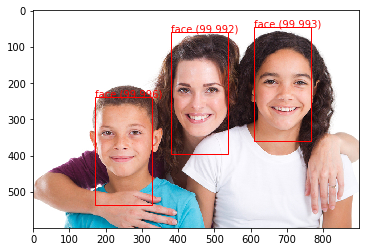

In [220]:



# make prediction
yolos = yolov3.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yolos])

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()

for i in range(len(yolos)):
        # decode the output of the network
    boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh,  net_h, net_w)

    # correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
do_nms(boxes, nms_thresh)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

# Age and gender detection with pre-trained model 

Trained with the Dataset : the **Adience** **dataset** in **kaggel** 

https://www.kaggle.com/ttungl/adience-benchmark-gender-and-age-classification

## Gender Recognition with CNN ( & OpenCV ) :

We will be using a different approach to recognize gender. This method was introduced by two Israel researchers, Gil Levi and Tal Hassner in 2015. We have used the CNN models trained by them in this example. We are going to use the OpenCV’s dnn package which stands for “Deep Neural Networks”.

A caffe model has 2 associated files :

    - 1 .prototxt — The definition of CNN goes in here. This file defines the layers in the neural network, each layer’s inputs, outputs and functionality.

    - 2 .caffemodel — This contains the information of the trained neural network (trained model).

In [221]:
import numpy as np
import cv2 as cv
img = cv.imread(photo_filename)

In [222]:
padding =20

In [223]:
gender_net = cv2.dnn.readNetFromCaffe('/Users/mac/Downloads/gad/gender_deploy.prototxt', '/Users/mac/Downloads/gad/gender_net.caffemodel')

In [224]:
gender_list = ['Male', 'Female']
MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

In [225]:
for i in range(len(v_boxes)):
    face = img[max(0,v_boxes[i].ymin-padding):min(v_boxes[i].ymax+padding,img.shape[0]-1),max(0,v_boxes[i].xmin-padding):min(v_boxes[i].xmax+padding,img.shape[1]-1)]
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    gender = gender_list[gender_preds[0].argmax()]
    print("Gender : " + gender)
    

Gender : Female
Gender : Female
Gender : Male


## Age Recognition with CNN ( & OpenCV )

The CNN’s **output layer** (probability layer) in this CNN consists of 8 values for **8 age** **classes** (“0–2”, “4–6”, “8–13”, “15–20”, “25–32”, “38–43”, “48–53” and “60-”)


In [226]:
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']


In [227]:
ageNet = cv.dnn.readNetFromCaffe("/Users/mac/Downloads/gad/age_deploy.prototxt","/Users/mac/Downloads/gad/age_net.caffemodel")


In [228]:
for i in range(len(v_boxes)):
    face = img[max(0,v_boxes[i].ymin-padding):min(v_boxes[i].ymax+padding,img.shape[0]-1),max(0,v_boxes[i].xmin-padding):min(v_boxes[i].xmax+padding,img.shape[1]-1)]
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    age = ageList[agePreds[0].argmax()]
    print("Age : "+ age)


Age : (8-12)
Age : (25-32)
Age : (8-12)


In [229]:
def age_gender(filename,v_boxes, v_gender , v_age):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='green')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s %s" % (v_gender[i], v_age[i])
        plt.text(x1, y1, label, color='red')
    # show the plot
    plt.show()

In [230]:
v_age = []
v_gender = []

for i in range(len(v_boxes)):
    
    face = img[max(0,v_boxes[i].ymin-padding):min(v_boxes[i].ymax+padding,img.shape[0]-1),max(0,v_boxes[i].xmin-padding):min(v_boxes[i].xmax+padding,img.shape[1]-1)]
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    gender = gender_list[gender_preds[0].argmax()]
    print("Gender : " + gender)
    v_gender.append(gender)
    
    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    age = ageList[agePreds[0].argmax()]
    v_age.append(age)
    print("Age : "+ age)
    
    
    
    

Gender : Female
Age : (8-12)
Gender : Female
Age : (25-32)
Gender : Male
Age : (8-12)


## Face , age and gender detection result :


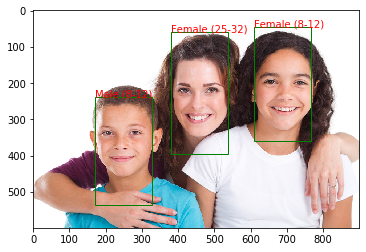

In [231]:
age_gender(photo_filename,v_boxes, v_gender , v_age)